In this post we will see how to use a local LLM to extract structured information from emails.

When I joined appliedAI Initiative in 2021, my first project involved using AI to extract information from emails for a company that develops a document management system. At that time, LLMs were not as advanced as they are today, so we decided to train a custom model from scratch. However, we faced challenges, particularly because we did not have labeled data, and due to privacy restrictions, we couldn't use the company's customer data. As a result, we resorted to manually labeling emails from the [Enron dataset](https://www.cs.cmu.edu/~enron/)[^enron].

[^enron]: Enron Corporation was an American energy, commodities, and services that went bankrupt in 2001 after ascandal involving a corporate fraud case. The Enron Email Dataset, containing 500,000 internal emails, provides valuable insights into the company’s operations and is widely used for research in text mining and network analysis.

Unfortunately, our approach yielded suboptimal results for several reasons, such as the mismatch between the Enron dataset and the actual customer emails and the lack of labeled training data. Today, however, extracting information from emails has become simpler than ever, and in this post, I want to demonstrate the improvements we can achieve with using LLMs.

In [1]:
# | echo: false

import random
import yaml
from datetime import datetime
from difflib import SequenceMatcher
from email.parser import Parser
from functools import partial
from statistics import fmean
from typing import Any, Callable, Literal

import numpy as np
import pandas as pd
import seaborn as sns
from llama_cpp import Llama
from pydantic import BaseModel
from tqdm.notebook import tqdm, trange

random.seed(16)
sns.set_theme(style="ticks", palette="pastel")

# Email information model

To start, we need define the model, and by extension the JSON schema, for the structured information we want to extract from the emails. For this, we use [Pydantic](https://docs.pydantic.dev/latest/) to define models for email information, the sender, and the recipient, along with methods to compare and compute similarity scores.

In [2]:
# | code-summary: "**EmailBaseModel**: Base model class for email-related information extraction."


class EmailBaseModel(BaseModel, extra="forbid"):
    """Base model class for email-related information extraction.

    This class extends BaseModel and provides common functionality for comparing
    string attributes between email information objects.

    Note:
        The extra="forbid" parameter ensures no additional attributes can be added
        beyond those explicitly defined.
    """

    @staticmethod
    def _compare_strings(a: str | None, b: str | None) -> float:
        """Computes similarity ratio between two possibly None strings.

        Uses SequenceMatcher to calculate string similarity when both inputs are
        not missing (None). Handles cases where one or both inputs are None.

        Args:
            a: First string to compare, or None
            b: Second string to compare, or None

        Returns:
            Similarity ratio between 0.0 and 1.0, where:
                - 1.0 indicates identical strings or both are None
                - 0.0 indicates completely different strings or one of them is None
                - Values between 0.0 and 1.0 indicate partial similarity
        """
        if a is None and b is None:
            similarity = 1.0
        elif a is not None and b is not None:
            similarity = SequenceMatcher(None, a, b).ratio()
        elif a is not None:
            similarity = 0.0
        else:
            similarity = 0.0
        return similarity

In [3]:
# | code-summary: "**Sender**: Represents a sender of an email with their associated information."


class Sender(EmailBaseModel):
    """Represents a sender of an email with their associated information.

    Stores and compares sender details including name, email, phone number,
    role, and organization.

    Attributes:
        name: The sender's full name if available
        email: The sender's email address
        phone_number: The sender's phone number if available
        role: The sender's professional role if available
        organization: The sender's organization if available
    """

    name: str | None = None
    email: str
    phone_number: str | None = None
    role: str | None = None
    organization: str | None = None

    def compare(self, other: "Sender") -> float:
        """Compares this sender with another sender object.

        Calculates similarity by comparing all attributes using string comparison
        and returns the mean similarity across all fields.

        Args:
            other: Another Sender object to compare against

        Returns:
            Mean similarity ratio between 0.0 and 1.0, where:
                - 1.0 indicates identical senders
                - 0.0 indicates completely different senders or invalid comparison
                - Values between 0.0 and 1.0 indicate partial similarity across fields

        Note:
            Returns 0.0 if other is not a Sender instance.
        """
        if not isinstance(other, Sender):
            return 0.0

        name_similarity = self._compare_strings(self.name, other.name)
        email_similarity = self._compare_strings(self.email, other.email)
        phone_number_similarity = self._compare_strings(
            self.phone_number, other.phone_number
        )
        role_similarity = self._compare_strings(self.role, other.role)
        organization_similarity = self._compare_strings(
            self.organization, other.organization
        )
        return fmean(
            [
                name_similarity,
                email_similarity,
                phone_number_similarity,
                role_similarity,
                organization_similarity,
            ]
        )

In [4]:
# | code-summary: "**Recipient**: Represents a recipient of an email with their associated information."


class Recipient(EmailBaseModel):
    """Represents a recipient of an email with their associated information.

    Stores and compares recipient details including name, email, phone number,
    role, organization, and their type of recipiency (to, cc, bcc).

    Attributes:
        name: The recipient's full name if available
        email: The recipient's email address
        phone_number: The recipient's phone number if available
        role: The recipient's professional role if available
        organization: The recipient's organization if available
        type: The type of recipient ("to", "cc", or "bcc")
    """

    name: str | None = None
    email: str
    phone_number: str | None = None
    role: str | None = None
    organization: str | None = None
    type: Literal["to", "cc", "bcc"] = "to"

    def compare(self, other: "Recipient") -> float:
        """Compares this recipient with another recipient object.

        Calculates similarity by comparing all attributes using string comparison
        and includes exact matching for recipient type. Returns the mean
        similarity across all fields.

        Args:
            other: Another Recipient object to compare against

        Returns:
            Mean similarity ratio between 0.0 and 1.0, where:
                - 1.0 indicates identical recipients
                - 0.0 indicates completely different recipients or invalid comparison
                - Values between 0.0 and 1.0 indicate partial similarity across fields

        Note:
            Returns 0.0 if other is not a Recipient instance.
            Recipient type comparison is binary: 1.0 if identical, 0.0 if different.
        """
        if not isinstance(other, Recipient):
            return 0.0

        name_similarity = self._compare_strings(self.name, other.name)
        email_similarity = self._compare_strings(self.email, other.email)
        phone_number_similarity = self._compare_strings(
            self.phone_number, other.phone_number
        )
        role_similarity = self._compare_strings(self.role, other.role)
        organization_similarity = self._compare_strings(
            self.organization, other.organization
        )
        type_similarity = 1.0 if self.type == other.type else 0.0
        return fmean(
            [
                name_similarity,
                email_similarity,
                phone_number_similarity,
                role_similarity,
                organization_similarity,
                type_similarity,
            ]
        )

In [5]:
# | code-summary: "**EmailInformation**: Represents information extracted from an email."


class EmailInformation(EmailBaseModel):
    """Represents information extracted from an email.

    Stores and compares email metadata including date, subject, sender information,
    and a list of recipients. Provides functionality to compare two email information
    objects for similarity.

    Attributes:
        date: The date of the email
        subject: The email subject line
        sender: Sender object containing sender information
        recipients: List of Recipient objects containing recipient information
    """

    date: str
    subject: str
    sender: Sender
    recipients: list[Recipient]

    def compare(self, other: "EmailInformation") -> float:
        """Compares this email information with another email information object.

        Performs a detailed comparison of all email attributes including sender
        and recipient information. For recipients, finds the best matching recipient
        pairs between the two emails and averages their similarities.

        Args:
            other: Another EmailInformation object to compare against

        Returns:
            Mean similarity ratio between 0.0 and 1.0, where:
                - 1.0 indicates identical email information
                - 0.0 indicates completely different emails or invalid comparison
                - Values between 0.0 and 1.0 indicate partial similarity across all fields

        Note:
            - Returns 0.0 if other is not an EmailInformation instance.
            - Returns 1.0 if self == other (exact match).
            - Recipient comparison finds the best matching recipient for each
              recipient in self.recipients among other.recipients.
        """
        if not isinstance(other, EmailInformation):
            return 0.0
        if self == other:
            return 1.0
        date_similarity = self._compare_strings(self.date, other.date)
        subject_similarity = self._compare_strings(self.subject, other.subject)
        sender_similarity = self.sender.compare(other.sender)

        if self.recipients == other.recipients:
            recipient_similarity = 1.0
        else:
            recipient_similarities = []
            for recipient_1 in self.recipients:
                recipient_1_similarity = 0.0
                for recipient_2 in other.recipients:
                    recipient_1_similarity = max(
                        recipient_1_similarity, recipient_1.compare(recipient_2)
                    )
                recipient_similarities.append(recipient_1_similarity)
            if recipient_similarities:
                recipient_similarity = fmean(recipient_similarities)
            else:
                recipient_similarity = 0.0

        return fmean(
            [
                date_similarity,
                subject_similarity,
                sender_similarity,
                recipient_similarity,
            ]
        )

To evaluate our approaches, we define a helper function to run the extraction on all emails in a given dataset and compute similarities.

In [6]:
# | code-summary: "**evaluate_extraction**: Function that evaluates an email information extraction function against a ground truth dataset."


def evaluate_extraction(
    extract_fn: Callable[[str], EmailInformation],
    dataset: list[dict[str, Any]],
) -> list[float]:
    """Evaluates an email information extraction function against a ground truth dataset.

    Processes each email in the dataset using the provided extraction function and
    compares the results against ground truth annotations using the EmailInformation
    comparison logic.

    Args:
        extract_fn: Function that takes a raw email string as input and returns
            an EmailInformation object containing the extracted information.
        dataset: List of dictionaries, where each dictionary contains:
            - 'raw_email': The raw email text to process
            - 'extracted_information': Ground truth EmailInformation object

    Returns:
        List of similarity scores between 0.0 and 1.0 for each email, where:
            - 1.0 indicates perfect extraction matching ground truth
            - 0.0 indicates completely incorrect extraction
            - Values between indicate partial matching of extracted information
    """
    scores = []

    for sample in tqdm(dataset, desc="Emails", leave=False):
        extracted_information = extract_fn(sample["raw_email"])

        score = sample["extracted_information"].compare(extracted_information)
        scores.append(score)

    return scores

# Data

For this exercise, we use 20 emails from the [Enron dataset](https://www.cs.cmu.edu/~enron/) that I labelled myself. We use 4 emails for the training set ( We will see later for what purpose we need such as set) and 16 emails for the test set.

In [7]:
# | echo: false

with open("enron_emails.yml") as f:
    all_email_data = yaml.safe_load(f)

for email_data in all_email_data:
    email_data["extracted_information"] = EmailInformation.model_validate(
        email_data["extracted_information"]
    )

all_indices = list(range(len(all_email_data)))
train_set_indices = random.choices(all_indices, k=int(0.2 * len(all_email_data)))
test_set_indices = list(set(all_indices).difference(train_set_indices))
train_set = [all_email_data[i] for i in train_set_indices]
test_set = [all_email_data[i] for i in test_set_indices]

In [8]:
# | echo: false

sample_test_email = train_set[1]
sample_raw_email = sample_test_email["raw_email"]
sample_email_information = sample_test_email["extracted_information"]

In [9]:
# | echo: false
# | output: asis

print(f"""Sample raw email:

```yaml
{sample_raw_email}
```
""")

Sample raw email:

```yaml
Message-ID: <23530825.1075858413552.JavaMail.evans@thyme>
Date: Thu, 10 May 2001 05:08:00 -0700 (PDT)
From: kam.keiser@enron.com
To: sabra.dinari@enron.com
Subject: FP&L
Cc: yuan.tian@enron.com, scott.neal@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: yuan.tian@enron.com, scott.neal@enron.com
X-From: Kam Keiser
X-To: Sabra L Dinari
X-cc: Yuan Tian, Scott Neal
X-bcc:
X-Folder: \Scott_Neal_Jun2001\Notes Folders\Notes inbox
X-Origin: Neal-S
X-FileName: sneal.nsf

Sabra,

I have extended the current FP&L sitara #217969 to the end of the deal
(2/2010).

Keeping the same deal # helps us keep up with the value.

I set it up with the volumes we booked in TAGG, I know the volumes and
locations will change but if you could send me and Yuan an e-mail when you
have made your change during bid week we will make the changes to the hedge
deal.


Thanks,

Kam


ps.  Scott, you will not see any problems with this d

In [10]:
# | echo: false
# | output: asis

print(f"""Sample ground truth extracted information:

```json
{sample_email_information.model_dump_json(indent=4)}"
```
""")

Sample ground truth extracted information:

```json
{
    "date": "10.05.2001",
    "subject": "FP&L",
    "sender": {
        "name": "Kam Keiser",
        "email": "kam.keiser@enron.com",
        "phone_number": null,
        "role": null,
        "organization": "Enron Corp."
    },
    "recipients": [
        {
            "name": "Sabra L. Dinari",
            "email": "sabra.dinari@enron.com",
            "phone_number": null,
            "role": null,
            "organization": "Enron Corp.",
            "type": "to"
        },
        {
            "name": "Scott Neal",
            "email": "scott.neal@enron.com",
            "phone_number": null,
            "role": null,
            "organization": "Enron Corp.",
            "type": "cc"
        },
        {
            "name": "Scott Neal",
            "email": "scott.neal@enron.com",
            "phone_number": null,
            "role": null,
            "organization": "Enron Corp.",
            "type": "bcc"
        },
 

# Approaches

## Baseline - Use Python's builtin email parser

As a baseline, we use Python’s built-in email parser from the [email](https://docs.python.org/3/library/email.examples.html) package to extract information. We define an extraction function that parses the emails and extracts basic information without much validation.

In [11]:
# | code-summary: "**extract_information_with_builtin_parser**: Function that extracts information using Python's built-in email parser."


def extract_information_with_builtin_parser(raw_email: str) -> EmailInformation:
    """Extracts structured information from a raw email using Python's built-in email parser.

    Parses the raw email text to extract metadata including date, subject, sender, and recipients.
    Handles special X-headers for additional information like sender and recipient names.

    Args:
        raw_email: Raw email text including headers and body.

    Returns:
        Structured object containing the extracted information with:
            - date: Formatted as DD.MM.YYYY
            - subject: Email subject line
            - sender: Sender information including email and optional name
            - recipients: List of recipients (to/cc/bcc) with email and optional name,
                sorted by email address
    """
    parser = Parser()
    email = parser.parsestr(raw_email)
    parsed_date = datetime.strptime(
        email["date"].strip().split("(")[0], "%a, %d %b %Y %H:%M:%S %z "
    )
    formatted_date = parsed_date.strftime("%d.%m.%Y")
    email_dict = {"date": formatted_date, "subject": email["subject"].strip()}
    sender = {"email": email["from"].strip()}
    if email["X-from"] and email["X-from"].strip() != email["from"]:
        sender["name"] = email["X-from"].strip()
    email_dict["sender"] = sender

    recipients = []
    for type_ in ["to", "cc", "bcc"]:
        recipient_names = email.get(f"X-{type_}", "").strip().split(",")
        recipient_emails = email.get(type_, None)
        if recipient_emails is None:
            continue
        recipient_emails = recipient_emails.split(",")
        if len(recipient_emails) != len(recipient_names):
            recipient_names = [""] * len(recipient_emails)
        for recipient_name, recipient_email in zip(recipient_names, recipient_emails):
            recipient = {"type": type_, "email": recipient_email.strip()}
            if recipient_name and recipient_name != recipient_email:
                recipient["name"] = recipient_name.strip()
            recipients.append(recipient)

    email_dict["recipients"] = list(sorted(recipients, key=lambda x: x["email"]))

    return EmailInformation.model_validate(email_dict)

In [12]:
# | echo: false

extracted_information = extract_information_with_builtin_parser(sample_raw_email)
builtin_test_scores = evaluate_extraction(
    extract_information_with_builtin_parser, test_set
)

Emails:   0%|          | 0/17 [00:00<?, ?it/s]

Using this method, we extract the following information from the sample test email:

In [13]:
# | echo: false
# | output: asis

print(f"""```json
{extracted_information.model_dump_json(indent=4)}"
```
""")

```json
{
    "date": "10.05.2001",
    "subject": "FP&L",
    "sender": {
        "name": "Kam Keiser",
        "email": "kam.keiser@enron.com",
        "phone_number": null,
        "role": null,
        "organization": null
    },
    "recipients": [
        {
            "name": "Sabra L Dinari",
            "email": "sabra.dinari@enron.com",
            "phone_number": null,
            "role": null,
            "organization": null,
            "type": "to"
        },
        {
            "name": "Scott Neal",
            "email": "scott.neal@enron.com",
            "phone_number": null,
            "role": null,
            "organization": null,
            "type": "cc"
        },
        {
            "name": null,
            "email": "scott.neal@enron.com",
            "phone_number": null,
            "role": null,
            "organization": null,
            "type": "bcc"
        },
        {
            "name": "Yuan Tian",
            "email": "yuan.tian@enron.com",
   

We also compute the average score of this approach on the test set:

In [14]:
# | echo: false
# | output: asis

print(f"{np.mean(builtin_test_scores) * 100:.2f}%")

84.29%


The results are plotted as a box plot, showing that while the extraction is relatively good, it is far from perfect.

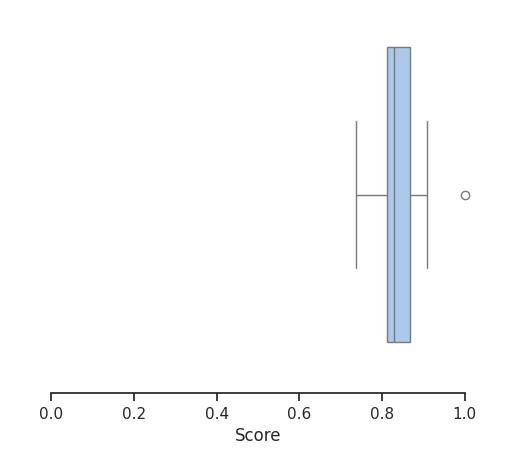

In [15]:
# | echo: false
# | fig-cap: Builtin Email Parser Score
# | fig-alt: Builtin Email Parser Score

ax = sns.boxplot(x=builtin_test_scores)
ax.set_xlim(left=-0.1, right=1.1)
ax.set_xlabel("Score")
sns.despine(offset=10, trim=True);

## First Approach - Use LLM zero-shot extraction with JSON schema

Next, we explore using an LLM for zero-shot extraction with a JSON schema. For this, we use [llama-cpp-python](https://llama-cpp-python.readthedocs.io/en/latest/), a Python wrapper for [llama.cpp](https://github.com/ggerganov/llama.cpp), to run a local LLM. This approach allows us to pass a JSON schema, ensuring structured output without needing to adjust the prompt repeatedly in order to coerce the LLM into generating valid JSON data.

> **Note**: There are [known performance issues](https://github.com/ggerganov/llama.cpp/blob/master/grammars/README.md#troubleshooting) with llama.cpp's structured output generation using grammars and, by extension, json schemas especially with nested objects.

We use a quantized version of Llama 3.2 3B Instruct with a context length of 16,384 tokens to handle long raw emails.

In [16]:
# | code-fold: false
# | output: false

llm = Llama.from_pretrained(
    "bartowski/Llama-3.2-3B-Instruct-GGUF",
    filename="Llama-3.2-3B-Instruct-Q8_0.gguf",
    n_ctx=16384,
    n_gpu_layers=-1,
    verbose=False,
)

llama_new_context_with_model: n_ctx_per_seq (16384) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


A system prompt is defined to guide the LLM, using a JSON type definition instead of a JSON schema, inspired by a blog post I came across. This version is shorter, produces better results, and is more human-readable.

We then define a system prompt to guide the LLM, using a JSON type definition instead of a JSON schema, inspired by [this blog post](https://www.boundaryml.com/blog/type-definition-prompting-baml) I came accross. The prompt with the type definition is shorter, produces better results and is more human-readable.

In [17]:
# | echo: false
# | output: asis

system_prompt = """You are a helpful assistant that extract information from a user provided email in JSON format that adheres to the following schema:

{
    "date": string,
    "subject": string,
    "sender": {
        "name": string | null,
        "email": string,
        "phone_number": string | null,
        "role": string | null,
        "organization": string | null
    },
    "recipients": {
        "name": string | null,
        "email": string,
        "phone_number": string | null,
        "role": string | null,
        "organization": string | null,
        "to": enum(["to", "cc", "bcc"])
    }[]
}
"""
print(f"""```json
{system_prompt}
```""")

```json
You are a helpful assistant that extract information from a user provided email in JSON format that adheres to the following schema:

{
    "date": string,
    "subject": string,
    "sender": {
        "name": string | null,
        "email": string,
        "phone_number": string | null,
        "role": string | null,
        "organization": string | null
    },
    "recipients": {
        "name": string | null,
        "email": string,
        "phone_number": string | null,
        "role": string | null,
        "organization": string | null,
        "to": enum(["to", "cc", "bcc"])
    }[]
}

```


In [18]:
# | code-summary: "**extract_information_with_llm**: Function that extracts information using an LLM"


def extract_information_with_llm(
    raw_email: str, *, system_prompt: str
) -> EmailInformation:
    """Extracts structured information from a raw email using an LLM.

    Uses chat completion API to parse email content into structured format.
    Enforces output schema validation using EmailInformation model specification.

    Args:
        raw_email: Raw email text including headers and body.
        system_prompt: System prompt for the LLM that defines the extraction task.

    Returns:
        Structured object containing the extracted information, validated against the EmailInformation schema.
    """
    response_format = {
        "type": "json_object",
        "schema": EmailInformation.model_json_schema(),
    }
    output = llm.create_chat_completion_openai_v1(
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {"role": "user", "content": raw_email},
        ],
        response_format=response_format,
        temperature=0.3,
    )
    extracted_information = EmailInformation.model_validate_json(
        output.choices[0].message.content
    )
    return extracted_information

In [19]:
# | echo: false

extracted_information = extract_information_with_llm(
    sample_raw_email, system_prompt=system_prompt
)
llm_test_scores = evaluate_extraction(
    partial(extract_information_with_llm, system_prompt=system_prompt), test_set
)

Emails:   0%|          | 0/17 [00:00<?, ?it/s]

Using this method, we extract the following information from the sample test email:

In [20]:
# | echo: false
# | output: asis

print(f"""Sample extracted information with llm zero-shot prompt:

```json
{extracted_information.model_dump_json(indent=4)}"
```
""")

Sample extracted information with llm zero-shot prompt:

```json
{
    "date": "Thu, 10 May 2001 05:08:00 -0700 (PDT)",
    "subject": "FP&L",
    "sender": {
        "name": "Kam Keiser",
        "email": "kam.keiser@enron.com",
        "phone_number": null,
        "role": "X-From",
        "organization": "X-Origin: Neal-S"
    },
    "recipients": [
        {
            "name": "Sabra L Dinari",
            "email": "sabra.dinari@enron.com",
            "phone_number": null,
            "role": "X-To",
            "organization": "X-Origin: Neal-S",
            "type": "to"
        },
        {
            "name": "Yuan Tian",
            "email": "yuan.tian@enron.com",
            "phone_number": null,
            "role": "X-cc",
            "organization": "X-Origin: Neal-S",
            "type": "cc"
        },
        {
            "name": "Scott Neal",
            "email": "scott.neal@enron.com",
            "phone_number": null,
            "role": "X-cc",
            "organi

We also compute the average score of this approach on the test set:

In [21]:
# | echo: false
# | output: asis

print(f"{np.mean(llm_test_scores) * 100:.2f}%")

64.55%


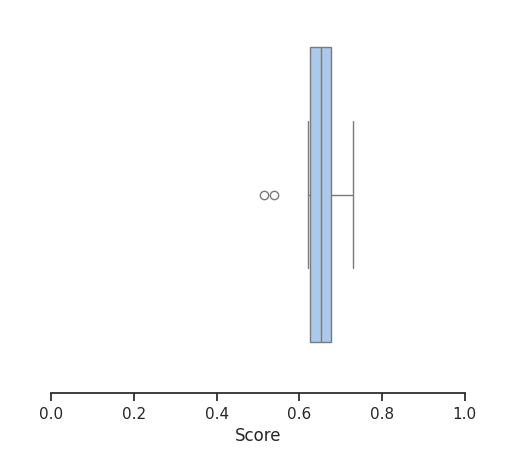

In [22]:
# | echo: false
# | fig-cap: LLM Zero-Shot Prompt Score
# | fig-alt: LLM Zero-Shot Prompt Score

ax = sns.boxplot(x=llm_test_scores)
ax.set_xlim(left=-0.1, right=1.1)
ax.set_xlabel("Score")
sns.despine(offset=10, trim=True);

We can see that this approach performs much worse than the previous one, most likely due to mismatch in expected formats. For example, we expected the date to be of the form `11.07.2001` instead of `11/07/2001`, `11 Jul 2001` or `Wed, 11 Jul 2001`.

To fix that, we will provide an example of information extraction in the system prompt in order to better guide the LLM.

## Second approach - LLM few-shot extraction with JSON schema

To improve performance, we move to a few-shot approach. Given context length and performance constraints, we use one example from the training set in the system prompt, making it a one-shot prompt approach.

We evaluate the impact of each example from the training set on the remaining examples in the training set to determine which one best improves the information extraction.

In [23]:
score_improvements = []

for i in trange(len(train_set), desc="Example"):
    example = train_set[i]
    train_set_without_example = train_set[:i] + train_set[i + 1 :]

    # We first compute the similarity with the zero-shot system prompt
    scores_zero_shot = evaluate_extraction(
        partial(extract_information_with_llm, system_prompt=system_prompt),
        train_set_without_example,
    )
    mean_score_zero_shot = np.mean(scores_zero_shot).item()

    # We then compute the similarity with the one-shot (with example) system prompt
    system_prompt_with_example = (
        system_prompt
        + f"""
Use the following example of raw email and extracted information as reference:

# Raw email

{example["raw_email"]}

# Extracted information

{example["extracted_information"].model_dump_json(indent=2)}
"""
    )
    scores_one_shot = evaluate_extraction(
        partial(extract_information_with_llm, system_prompt=system_prompt_with_example),
        train_set_without_example,
    )
    mean_score_one_shot = np.mean(scores_one_shot).item()
    # We then compute the difference in similarity
    score_improvement = mean_score_one_shot - mean_score_zero_shot
    score_improvements.append(
        (
            score_improvement,
            system_prompt_with_example,
        )
    )

Example:   0%|          | 0/4 [00:00<?, ?it/s]

Emails:   0%|          | 0/3 [00:00<?, ?it/s]

Emails:   0%|          | 0/3 [00:00<?, ?it/s]

Emails:   0%|          | 0/3 [00:00<?, ?it/s]

Emails:   0%|          | 0/3 [00:00<?, ?it/s]

Emails:   0%|          | 0/3 [00:00<?, ?it/s]

Emails:   0%|          | 0/3 [00:00<?, ?it/s]

Emails:   0%|          | 0/3 [00:00<?, ?it/s]

Emails:   0%|          | 0/3 [00:00<?, ?it/s]

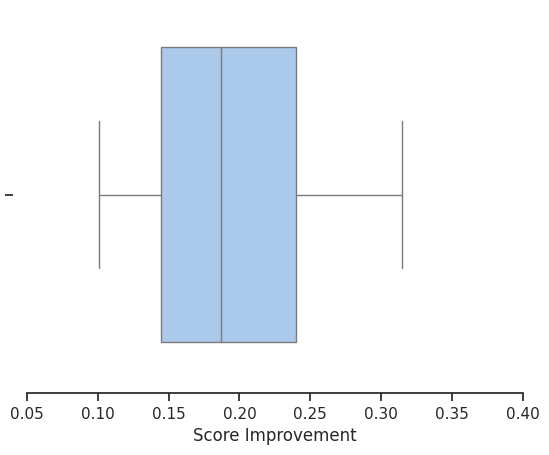

In [45]:
# | echo: false
# | fig-cap: LLM One-Shot Prompt Score Improvement
# | fig-alt: LLM One-Shot Prompt Score Improvement

ax = sns.boxplot(x=[x[0] for x in score_improvements])
ax.set_xlabel("Score Improvement")
ax.set_xlim(left=0.05, right=0.4)
sns.despine(offset=10, trim=True);

In [25]:
# | echo: false

best_index = np.argmax([x[0] for x in score_improvements])
best_score_improvement = score_improvements[best_index][0]
best_system_prompt_with_example = score_improvements[best_index][1]

In [26]:
# | echo: false
# | output: asis

print(f"""The best score improvement we can obtain using the one-shot prompt and out small train set is: {best_score_improvement * 100:.2f}

The system prompt and, by extension, example corresponding to this improvement are:

```json
{best_system_prompt_with_example}
```
""")

The best score improvement we can obtain using the one-shot prompt and out small train set is: 31.45

The system prompt and, by extension, example corresponding to this improvement are:

```json
You are a helpful assistant that extract information from a user provided email in JSON format that adheres to the following schema:

{
    "date": string,
    "subject": string,
    "sender": {
        "name": string | null,
        "email": string,
        "phone_number": string | null,
        "role": string | null,
        "organization": string | null
    },
    "recipients": {
        "name": string | null,
        "email": string,
        "phone_number": string | null,
        "role": string | null,
        "organization": string | null,
        "to": enum(["to", "cc", "bcc"])
    }[]
}

Use the following example of raw email and extracted information as reference:

# Raw email

Message-ID: <7555575.1075857946274.JavaMail.evans@thyme>
Date: Mon, 30 Apr 2001 11:17:00 -0700 (PDT)
From: cat

In [46]:
# | echo: false

extracted_information = extract_information_with_llm(
    sample_raw_email, system_prompt=best_system_prompt_with_example
)
few_shot_llm_test_scores = evaluate_extraction(
    partial(
        extract_information_with_llm, system_prompt=best_system_prompt_with_example
    ),
    test_set,
)

Emails:   0%|          | 0/17 [00:00<?, ?it/s]

Using this method, we extract the following information from the sample test email:

In [47]:
# | echo: false
# | output: asis

print(f"""Sample extracted information with llm one-shot prompt:

```json
{extracted_information.model_dump_json(indent=4)}"
```
""")

Sample extracted information with llm one-shot prompt:

```json
{
    "date": "10.05.2001",
    "subject": "FP&L",
    "sender": {
        "name": "Kam Keiser",
        "email": "kam.keiser@enron.com",
        "phone_number": null,
        "role": null,
        "organization": "Enron"
    },
    "recipients": [
        {
            "name": "Sabra L Dinari",
            "email": "sabra.dinari@enron.com",
            "phone_number": null,
            "role": null,
            "organization": "Enron",
            "type": "to"
        },
        {
            "name": "Yuan Tian",
            "email": "yuan.tian@enron.com",
            "phone_number": null,
            "role": null,
            "organization": "Enron",
            "type": "cc"
        },
        {
            "name": "Scott Neal",
            "email": "scott.neal@enron.com",
            "phone_number": null,
            "role": null,
            "organization": "Enron",
            "type": "cc"
        }
    ]
}"
```



The average score of this second approach on the test set is:

In [48]:
# | echo: false
# | output: asis

print(f"{np.mean(few_shot_llm_test_scores) * 100:.2f}%")

87.27%


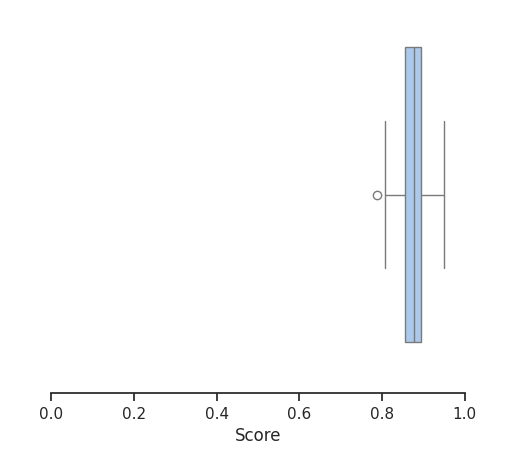

In [49]:
# | echo: false
# | fig-cap: LLM One-Shot Prompt Score
# | fig-alt: LLM One-Shot Prompt Score

ax = sns.boxplot(x=few_shot_llm_test_scores)
ax.set_xlim(left=-0.1, right=1.1)
ax.set_xlabel("Score")
sns.despine(offset=10, trim=True);

## Comparison of the 3 approaches

When comparing the scores of the three approaches, it is clear that both the baseline parser and the few-shot approach outperform the zero-shot approach. The few-shot approach is more flexible and generalizes better, which could prove beneficial when scaling to larger datasets.

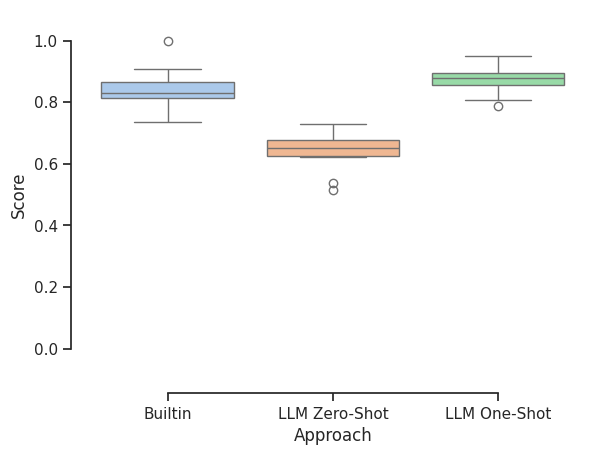

In [50]:
# | echo: false
# | fig-cap: LLM One-Shot Prompt Score
# | fig-alt: LLM One-Shot Prompt Score

df = pd.DataFrame(
    {
        "Builtin": builtin_test_scores,
        "LLM Zero-Shot": llm_test_scores,
        "LLM One-Shot": few_shot_llm_test_scores,
    }
)

ax = sns.boxplot(data=df)
ax.set_ylim(bottom=-0.1, top=1.1)
ax.set_xlabel("Approach")
ax.set_ylabel("Score")
sns.despine(offset=10, trim=True);

# Conclusion

In this post, we have seen how a local LLM can be used to extract structured information from emails, provided you have access to the email content and the necessary permissions. We also explored how adding an example to the system prompt (few-shot prompting) can significantly improve the extraction.

This post is intended as a demonstration of how structured information extraction can be done with modern LLMs. For real-world applications, however, you would likely face additional constraints, such as more complex datasets, stricter privacy considerations, and the need for larger datasets to improve accuracy and robustness.